# Siamese Networks


## Introduction

Let's start with what are siamese networks? 

A siamese neural network consists of same network typically a CNN, which accept distinct inputs and generates embeddings as output. We add different loss functions to encourage brining similar images together and different images apart in embedding space. Siamese NNs are popular among tasks that involve finding similarity or a relationship between two comparable things. Siamese networks typically share the same base network (CNN) which can be used as embedding extractor i.e. 3 inputs for triplet loss which will generate 3 outputs of embedding size of 128 or 2 inputs for contrastive loss will generate 2 outputs of embedding size of 128. 


---

## Types of Siamese Networks

Siamese Networks come in two flavours: using triplet loss and another using contrastive loss. Let's visit each of them.


- **Triplets Loss**

Triplets, are basically 3 images (yeah, no brainer!) which are anchor, positive and negative. What are these? **The anchor is any example from dataset. The positive is any example other than anchor belonging to same class as anchor.** And finally, **negative is any example belonging to class other than that of the anchor. In triplet loss, what we do is sample lot's of triplets.** There are different ways to sample triplets (or known as mining triplets) and this is what makes and breaks triplet loss approach. For some distance on the embedding space d, the loss of a triplet (a,p,n) is

$$\mathcal{L} = max(d(a, p) - d(a, n) + margin, 0)$$


There are different kinds of triplets such as easy triplets, semi-hard triplets, hard triplets. **Easy triplets are triplets which have loss 0**, because $$d(a, p) + margin < d(a,n)$$ **Semi-hard triplets are triplets where the negative is not closer to the anchor than the positive, but which still have positive loss,** i.e. $$d(a, p) < d(a, n) < d(a, p) + margin$$ **Hard Triplets are triplets where the negative is closer to the anchor than the positive**, i.e. $$d(a,n) < d(a,p)$$


In the original Facenet paper, they pick a random semi-hard negative for every pair of anchor and positive, and train on these triplets and also according to paper, selecting the hardest negatives can in practice lead to bad local minima early on in training. "Additionally, the selected triplets can be considered moderate triplets, since they are the hardest within a small subset of the data, which is exactly what is best for learning with the triplet loss", according to [this](https://arxiv.org/abs/1703.07737) paper. So, there is no thumb rule but starting with semi-hard yields good results and poor results with easy triplets.


Now having decided what strategy to use for batching the triplets, comes the challenge of training on batch of triplets. There are two ways in which batches of triplets can be trained : (i) **Offline triplet mining, where we produce triplets offline, at the beginning of each epoch for instance.** We compute all the embeddings on the training set, and then only select hard or semi-hard triplets. We can then train one epoch on these triplets. (ii) **Online triplet mining, where we compute useful triplets on the fly, for each batch of inputs.** This technique gives you more triplets for a single batch of inputs, and doesn’t require any offline mining. It is therefore much more efficient. Details of each method are described in [this](https://arxiv.org/abs/1703.07737) paper.

 The motivation is that the triplet loss encourages all examples belonging to same class i.e. of one  identity to be projected onto a single point in the embedding  space.


- **Contrastive Loss**

This the simplest among the two. Here, we sample two pairs of images, one **positive** and another **negative** or also known as, **similar** and **different**  pairs unlike above where we sample triplets. The two pairs i.e. **similar which contains any two images belonging to similar class** and **different where any two images belong to different class.** So, we create a lot many such similar and different pairs and pass it to any CNN architecture without the head(classification layer) and use the dimension of penultimate layer or add any number of linear layers  to obtain embeddings of size, say 128. Different name for loss suggests, we are not using our typical classification loss such as NLL or cross entropy for classification as there is no classification layer. So, how can we train our model (as in, what to backpropogate)? The answer is contrastive loss. **Contrastive Loss is a distance-based loss where such losses try to ensure that semantically similar examples are embedded close together.** This is what makes them special for our case, where we want similar images to be present closer in the embedding space and push different pairs away. We can also train by adding cross entropy as loss function with labels as 0 for similar images and 1 for different images. To learn more about this loss function, please read the paper linked below.


---

## Further Readings

[Signature Verification using a "Siamese" Time Delay Neural Network ](https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf)

[Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

[Facenet paper introducing Triplets](https://arxiv.org/abs/1503.03832)

[Contrastive Loss paper](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

[In defense of Triplet Loss for Person Re-identification](https://arxiv.org/abs/1703.07737)

[Andrew Ng's Triplet Loss Lecture](https://www.coursera.org/learn/convolutional-neural-networks/lecture/HuUtN/triplet-loss)

[Triplet Loss and Online Triplet Mining in TensorFlow](https://omoindrot.github.io/triplet-loss)

---

## Experiements

Here we will start small with everyone's favourite dataset MNIST. (Yay!!) We will implement both triplet loss and contrastive loss siamese networks on MNIST and obtain the projections using t-SNE on embeddings trained on siamese model to see how different clusters are formed and how far are they separated indicating they have been successful in performing their task.


For our experiment, we tried implementing both losses in keras and fastai.


# Keras

In [0]:
import keras
import random
import tensorflow as tf
import numpy as np
import time
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Layer, Input, concatenate, Concatenate
from functools import partial, update_wrapper
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(42)

In [0]:
(train_X, train_Y), (val_X, val_Y) = mnist.load_data()
print ('Training shape:', train_X.shape, train_Y.shape)
print ('Validation shape:', val_X.shape, val_Y.shape)

Training shape: (60000, 28, 28) (60000,)
Validation shape: (10000, 28, 28) (10000,)


In [0]:
img_size = 28
input_shape = (28, 28, 1)
num_classes = 10

In [0]:
train_x = train_X.astype('float32')
val_x = val_X.astype('float32')
train_x /= 255
val_x /= 255

train_y = to_categorical(train_Y, num_classes=num_classes)
val_y = to_categorical(val_Y, num_classes=num_classes)
print ('Training shape:', train_x.shape, train_y.shape)
print ('Validation shape:', val_x.shape, val_y.shape)

Training shape: (60000, 28, 28) (60000, 10)
Validation shape: (10000, 28, 28) (10000, 10)


In [0]:
def siamese_network():
    
    inp = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(inp)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(x)
    
    return Model(inputs=inp, outputs=norm_layer)

In [0]:
siamese_model = siamese_network()
siamese_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
__________

## Method - 1 (Triplet Loss)

### FInd hard positives and negatives using embedding distance

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
#Form batches by randomly sampling P classes (person identities), 
#and then randomly sampling K images of each class (person)
#resulting in a batch of PK images.
#Choose B, P, and K in such a way that 3B is close to PK
#P = 42, K = 4, B = 96

#For each sample a in the batch, we can select the hardest positive 
#and the hardest negative samples within the batch when forming the triplets 
#for computing the loss, which we call Batch Hard

#The selected triplets can be considered moderate triplets, 
#since they are the hardest within a small subset of the data, 
#which is exactly what is best for learning with the triplet loss

class BatchHard:
    
    def __init__(self, batch_size, P):
        self.P = P
        self.batch_size = batch_size
        
    def get_batch(self):
        
        #randomly sample P classes based on probability distribution of classes
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)
        #print (P_classes)
        batch_samples = []
        anchors = []
        positives = []
        negatives = []
        j = 0        

        #for each class in P
        for i in P_classes:
            #find the instances of same class
            lbl_index = np.where(train_Y == i)
            #sample 1 images of each classes
            random_index = np.random.choice(lbl_index[0], size=1)
            #batch of P images
            batch_samples.append(train_X[random_index])
            j += 1

        batch_samples = np.squeeze(batch_samples)
        batch = batch_samples.reshape((-1, 28, 28, 1))

        #pass the batch of P images to siamese network to predict embeddings for each image
        pred_batch_samples = siamese_model.predict(batch)

        #find all hardest positive and hard negative for each a in batch
        for i in range(len(batch_samples)):
            #print ('Current:', P_classes[i])
            similar_class = np.where(P_classes == P_classes[i])[0]
            diff_class = np.where(P_classes != P_classes[i])[0]
            #print ('Similar Class:', similar_class)
            #print ('Different Class:', diff_class)

            a = pred_batch_samples[i]
            anchors.append(batch_samples[i])
            #print ('Anchor predicted embedding:', a, a.shape)

            # find hard positive
            positive_dist = []
            #print ('Positive predicted embedding:')
            for sim_index in similar_class:
                #print (pred_batch_samples[sim_index], pred_batch_samples[sim_index].shape)
                positive_dist.append(np.linalg.norm(a-pred_batch_samples[sim_index]))
            #print ('Positive:', positive_dist, similar_class[np.argmax(np.array(positive_dist))])
            positives.append(batch_samples[similar_class[np.argmax(np.array(positive_dist))]])

            # find hard negative
            negative_dist = []
            for diff_index in diff_class:
                negative_dist.append(np.linalg.norm(a-pred_batch_samples[diff_index]))
            #print ('Negative:', negative_dist, diff_class[np.argmin(np.array(negative_dist))])
            negatives.append(batch_samples[diff_class[np.argmin(np.array(negative_dist))]])
        anchors = np.array(anchors)
        anchors = anchors.reshape(-1, anchors.shape[-2], anchors.shape[-1])
        positives = np.array(positives)
        positives = positives.reshape(-1, positives.shape[-2], positives.shape[-1])
        negatives = np.array(negatives)
        negatives = negatives.reshape(-1, negatives.shape[-2], negatives.shape[-1])
        self.triplets = [np.expand_dims(anchors, axis=-1), np.expand_dims(positives, axis=-1), np.expand_dims(negatives, axis=-1)]

        return np.array(self.triplets)

    def show_samples(self, anchors, positives, negatives):
        rand_index = random.sample(list(np.arange(anchors.shape[0])), 4) 
        fig, ax = plt.subplots(4, 3)
        ax[0][0].imshow(np.squeeze(anchors[rand_index[0]]))
        ax[0][1].imshow(np.squeeze(positives[rand_index[0]]))
        ax[0][2].imshow(np.squeeze(negatives[rand_index[0]]))
        ax[1][0].imshow(np.squeeze(anchors[rand_index[1]]))
        ax[1][1].imshow(np.squeeze(positives[rand_index[1]]))
        ax[1][2].imshow(np.squeeze(negatives[rand_index[1]]))
        ax[2][0].imshow(np.squeeze(anchors[rand_index[2]]))
        ax[2][1].imshow(np.squeeze(positives[rand_index[2]]))
        ax[2][2].imshow(np.squeeze(negatives[rand_index[2]]))
        ax[3][0].imshow(np.squeeze(anchors[rand_index[3]]))
        ax[3][1].imshow(np.squeeze(positives[rand_index[3]]))
        ax[3][2].imshow(np.squeeze(negatives[rand_index[3]]))
        plt.show()
    
#     # data generator for triplets
#     def batch_generator(self):
#         i = 0
#         while True:
#             a_embed = np.array(self.triplets[0][i:i+self.batch_size])
#             p_embed = np.array(self.triplets[1][i:i+self.batch_size])
#             n_embed = np.array(self.triplets[2][i:i+self.batch_size])
#             print (np.array(self.triplets).shape)
#             print (i, i+self.batch_size)
#             print (a_embed.shape, p_embed.shape, n_embed.shape)
#             i += self.batch_size

#             yield (np.concatenate([a_embed, p_embed, n_embed], axis=0), np.zeros(3*self.batch_size))
            
#     # return data generator for triplets
#     def get_generator(self):
#         gen = self.batch_generator()
#         return gen

In [0]:
class TripletLossLayer(Layer):
    
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=1)
        n_dist = K.sum(K.square(a-n), axis=1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [0]:
a_inp = Input(shape=(28, 28, 1))
p_inp = Input(shape=(28, 28, 1))
n_inp = Input(shape=(28, 28, 1))

In [0]:
a_embed = siamese_model(a_inp)
p_embed = siamese_model(p_inp)
n_embed = siamese_model(n_inp)

In [0]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_embed, p_embed, n_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[a_inp, p_inp, n_inp], outputs=triplet_loss_layer)

In [0]:
model.summary()
model.compile(loss=None, optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          1198592     input_7[0][0]                    
                                                                 input_8[0][0]                    
          

In [0]:
batch_size = 60
P = 20000

In [0]:
batches = BatchHard(batch_size, P)
triplets = batches.get_batch()
a = np.array(triplets[0])
p = np.array(triplets[1])
n = np.array(triplets[2])

In [0]:
model.fit([a, p, n], None, epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50
20000/20000 [==============================] - 4s 224us/step - loss: 5.3933
Epoch 2/50
20000/20000 [==============================] - 4s 195us/step - loss: 1.0430
Epoch 3/50
20000/20000 [==============================] - 4s 188us/step - loss: 0.5894
Epoch 4/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.3798
Epoch 5/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.2910
Epoch 6/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1995
Epoch 7/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1708
Epoch 8/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1668
Epoch 9/50
20000/20000 [==============================] - 4s 191us/step - loss: 0.1227
Epoch 10/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1190
Epoch 11/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1274
Epoch 12/50
20000/20000 [================

#### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          1198592     input_7[0][0]                    
                                                                 input_8[0][0]                    
          

In [0]:
model.layers[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(a_inp, a_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_3 (Model)              (None, 128)               1198592   
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_trm = tmp_model.predict(train_x.reshape(-1,28,28,1))

Classifier_input = Input((128,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm, train_y, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 2.2380 - acc: 0.2377
Epoch 2/10
60000/60000 [==============================] - 5s 78us/step - loss: 2.1292 - acc: 0.4381
Epoch 3/10
60000/60000 [==============================] - 5s 78us/step - loss: 2.0372 - acc: 0.5031
Epoch 4/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.9579 - acc: 0.5386
Epoch 5/10
60000/60000 [==============================] - 5s 77us/step - loss: 1.8887 - acc: 0.5583
Epoch 6/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.8280 - acc: 0.5679
Epoch 7/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.7739 - acc: 0.5774
Epoch 8/10
60000/60000 [==============================] - 5s 79us/step - loss: 1.7260 - acc: 0.5857
Epoch 9/10
60000/60000 [==============================] - 5s 90us/step - loss: 1.6829 - acc: 0.5913
Epoch 10/10
60000/60000 [==============================] - 5s 88us/step - loss: 1.6439 - acc: 0.5978

In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 128)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

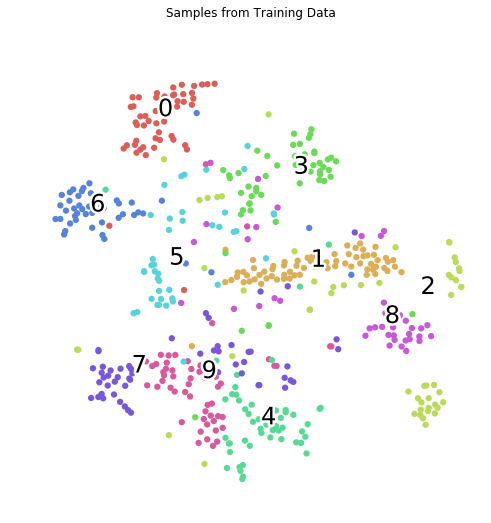

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

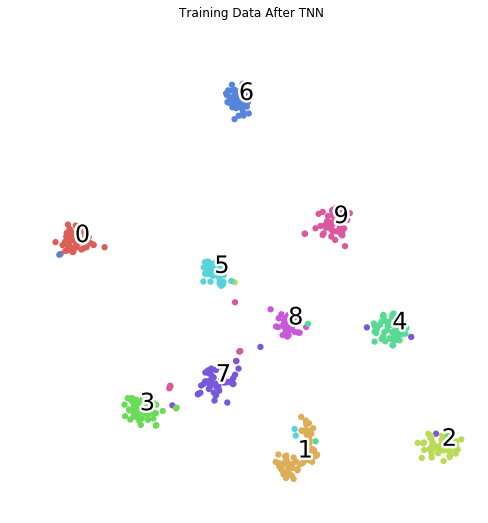

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-6.717429,8.386817,5.0
1,-28.196423,15.490483,0.0
2,16.823631,1.653309,4.0
3,2.417643,-22.085928,1.0
4,10.743126,19.940912,9.0


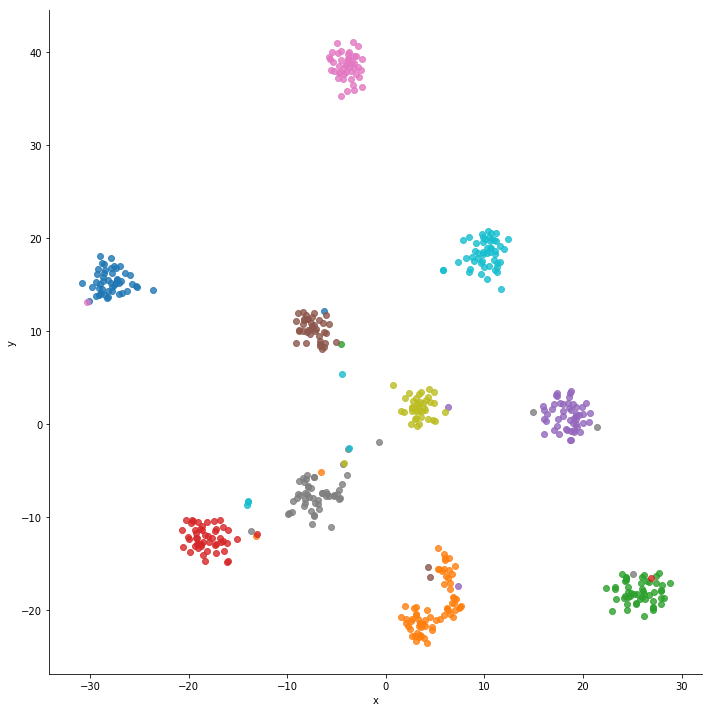

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

### Finding hard positives and negatives using image distance

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
#Form batches by randomly sampling P classes (person identities), 
#and then randomly sampling K images of each class (person)
#resulting in a batch of PK images.
#Choose B, P, and K in such a way that 3B is close to PK
#P = 42, K = 4, B = 96

#For each sample a in the batch, we can select the hardest positive 
#and the hardest negative samples within the batch when forming the triplets 
#for computing the loss, which we call Batch Hard

#The selected triplets can be considered moderate triplets, 
#since they are the hardest within a small subset of the data, 
#which is exactly what is best for learning with the triplet loss

class BatchHard:
    
    def __init__(self, batch_size, P, N):
        self.P = P
        self.N = N
        self.batch_size = batch_size
        
    def get_batch(self):
        
        #randomly sample P classes based on probability distribution of classes
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)
        batch_samples = [[] for _ in range(self.P)]
        anchors = [[] for _ in range(self.P)]
        positives = [[] for _ in range(self.P)]
        negatives = [[] for _ in range(self.P)]
        j = 0        
        
        #for each class in P
        for i in P_classes:
            #find the instances of same class
            lbl_index = np.where(train_Y == i)
            #sample K images of each classes
            random_index = np.random.choice(lbl_index[0], size=self.N)
            #batch of PK images
            batch_samples[j].append(train_X[random_index])
            j += 1

        batch_samples = np.squeeze(batch_samples)
        
        #find all hardest positive and hard negative for each a in batch
        for i in range(len(batch_samples)):
            similar_class = np.where(P_classes == P_classes[i])[0]
            
            j = 0
            while(j < self.N):
                a = batch_samples[i][j]
                anchors[i].append(a)
                
                #find hard positive
                positive_dist = [[] for _ in range(self.P)]
                for p in range(self.P):
                    if p not in similar_class :
                        positive_dist[p].append([0]*self.N)           
                    else:
                        for k in range(self.N):
                            positive_dist[p].append(np.linalg.norm(a-batch_samples[p][k]))
                    positive_dist[p] = np.squeeze(np.array(positive_dist[p]))   
                positives[i].append(batch_samples[np.argmax(np.array(positive_dist)) // self.N][np.argmax(np.array(positive_dist)) % self.N])
                
                #find hard negative             
                negative_dist = [[] for _ in range(self.P)]
                for p in range(self.P):
                    if p in similar_class :
                        negative_dist[p].append([np.nan]*self.N)           
                    else:
                        for k in range(self.N):
                            negative_dist[p].append(np.linalg.norm(a-batch_samples[p][k]))
                    negative_dist[p] = np.squeeze(np.array(negative_dist[p]))                

                negatives[i].append(batch_samples[np.nanargmin(np.array(negative_dist)) // self.N][np.nanargmin(np.array(negative_dist)) % self.N])
                j+=1
 
        anchors = np.array(anchors)
        anchors = anchors.reshape(-1, anchors.shape[-2], anchors.shape[-1])
        positives = np.array(positives)
        positives = positives.reshape(-1, positives.shape[-2], positives.shape[-1])
        negatives = np.array(negatives)
        negatives = negatives.reshape(-1, negatives.shape[-2], negatives.shape[-1])
        self.triplets = [np.expand_dims(anchors, axis=-1), np.expand_dims(positives, axis=-1), np.expand_dims(negatives, axis=-1)]
        
        return np.array(self.triplets)
 
    def show_samples(self, anchors, positives, negatives):
        print (anchors.shape, anchors[0].shape, anchors[0][0].shape)
        fig, ax = plt.subplots(4, 3)
        ax[0][0].imshow(np.squeeze(anchors[0]))
        ax[0][1].imshow(np.squeeze(positives[0]))
        ax[0][2].imshow(np.squeeze(negatives[0]))
        ax[1][0].imshow(np.squeeze(anchors[1]))
        ax[1][1].imshow(np.squeeze(positives[1]))
        ax[1][2].imshow(np.squeeze(negatives[1]))
        ax[2][0].imshow(np.squeeze(anchors[2]))
        ax[2][1].imshow(np.squeeze(positives[2]))
        ax[2][2].imshow(np.squeeze(negatives[2]))
        ax[3][0].imshow(np.squeeze(anchors[3]))
        ax[3][1].imshow(np.squeeze(positives[3]))
        ax[3][2].imshow(np.squeeze(negatives[3]))
        plt.show()

#     # data generator for triplets
#     def batch_generator(self):
#         i = 0
#         while True:
#             a_embed = np.array(self.triplets[0][i:i+self.batch_size])
#             p_embed = np.array(self.triplets[1][i:i+self.batch_size])
#             n_embed = np.array(self.triplets[2][i:i+self.batch_size])
#             print (i, i+self.batch_size)
#             print (a_embed.shape, p_embed.shape, n_embed.shape)
#             print (a_embed)
#             i += self.batch_size

#             yield [a_embed, p_embed, n_embed], None
            
#     # return data generator for triplets
#     def get_generator(self):
#         gen = self.batch_generator()
#         return gen       

In [0]:
class TripletLossLayer(Layer):
    
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=1)
        n_dist = K.sum(K.square(a-n), axis=1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [0]:
a_inp = Input(shape=(28, 28, 1))
p_inp = Input(shape=(28, 28, 1))
n_inp = Input(shape=(28, 28, 1))

In [0]:
a_embed = siamese_model(a_inp)
p_embed = siamese_model(p_inp)
n_embed = siamese_model(n_inp)

In [0]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_embed, p_embed, n_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[a_inp, p_inp, n_inp], outputs=triplet_loss_layer)

In [0]:
model.summary()
model.compile(loss=None, optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 128)          1198592     input_13[0][0]                   
                                                                 input_14[0][0]                   
          

In [0]:
batch_size = 32
epochs = 0
P = 500
N = 40
batches = BatchHard(batch_size, P, N)
num_samples = P*N

In [0]:
triplets = batches.get_batch()
a = np.array(triplets[0])
p = np.array(triplets[1])
n = np.array(triplets[2])

In [0]:
model.fit([a, p, n], None, epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50
20000/20000 [==============================] - 6s 285us/step - loss: 1.1472
Epoch 2/50
20000/20000 [==============================] - 5s 256us/step - loss: 0.3572
Epoch 3/50
20000/20000 [==============================] - 5s 256us/step - loss: 0.2159
Epoch 4/50
20000/20000 [==============================] - 5s 255us/step - loss: 0.1425
Epoch 5/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0870
Epoch 6/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0732
Epoch 7/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0639
Epoch 8/50
20000/20000 [==============================] - 5s 253us/step - loss: 0.0618
Epoch 9/50
20000/20000 [==============================] - 5s 265us/step - loss: 0.0430
Epoch 10/50
20000/20000 [==============================] - 5s 271us/step - loss: 0.0384
Epoch 11/50
20000/20000 [==============================] - 5s 255us/step - loss: 0.0436
Epoch 12/50
20000/20000 [================

#### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 128)          1198592     input_13[0][0]                   
                                                                 input_14[0][0]                   
          

In [0]:
model.layers[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(a_inp, a_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
model_10 (Model)             (None, 128)               1198592   
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_trm = tmp_model.predict(train_x.reshape(-1,28,28,1))

Classifier_input = Input((128,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm, train_y, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.6081 - acc: 0.8052
Epoch 2/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.8593 - acc: 0.9072
Epoch 3/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.5675 - acc: 0.9113
Epoch 4/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.4340 - acc: 0.9136
Epoch 5/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.3649 - acc: 0.9162
Epoch 6/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.3258 - acc: 0.9177
Epoch 7/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3019 - acc: 0.9194
Epoch 8/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.2860 - acc: 0.9207
Epoch 9/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2750 - acc: 0.9218
Epoch 10/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2669 - acc: 0.9227

In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 128)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

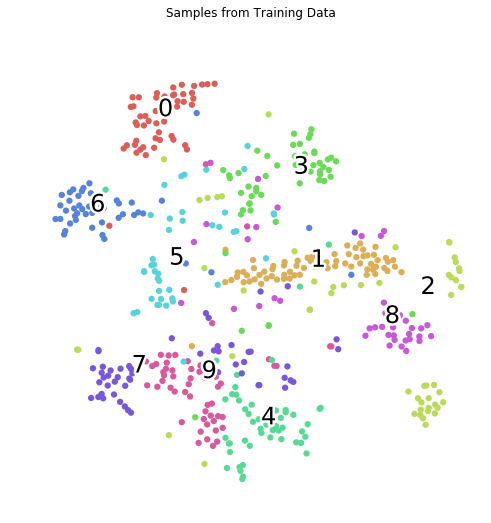

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

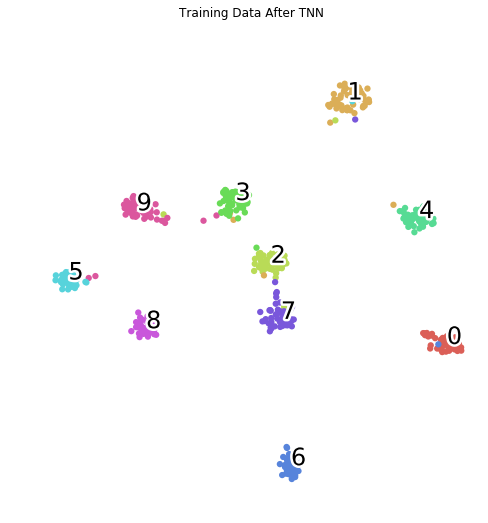

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-32.830582,-3.567229,5.0
1,27.243023,-15.246427,0.0
2,20.956648,9.557454,4.0
3,11.588186,30.425179,1.0
4,-20.081406,9.931993,9.0


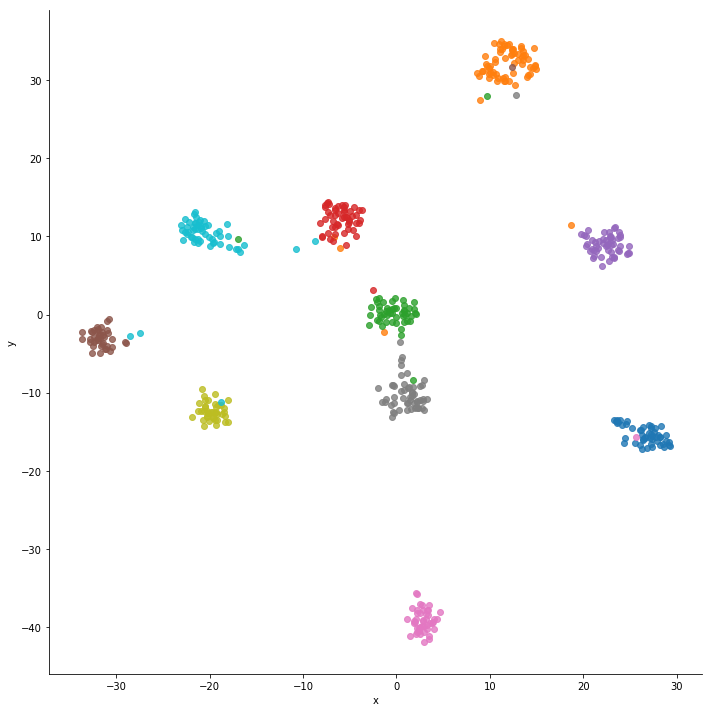

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

## Method - 2 (Contrastive Loss)

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
class SampleBatch:
    
    def __init__(self, num_pairs, batch_size):
        self.batch_size = batch_size
        self.P = num_pairs
        
    def get_batch(self):
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)

        batch_samples = [[] for _ in range(self.P)]
        pairs1 = [[] for _ in range(self.P)]
        pairs2 = [[] for _ in range(self.P)]


        for i in range(len(P_classes)):
            lbl = P_classes[i]

            same_class_index = np.where(train_Y == lbl)[0]
            diff_class_index = np.where(train_Y != lbl)[0]

            pos_index = random.sample(list(same_class_index), k=3)
            neg_index = random.sample(list(diff_class_index), k=1)

            pairs1[i].append(np.expand_dims(np.array(train_x[pos_index[0]]), axis=-1))
            pairs1[i].append(np.expand_dims(np.array(train_x[pos_index[1]]), axis=-1))
            pairs1[i].append(1)
            pairs2[i].append(np.expand_dims(np.array(train_x[pos_index[2]]), axis=-1))
            pairs2[i].append(np.expand_dims(np.array(train_x[neg_index[0]]), axis=-1))
            pairs2[i].append(0)
            pairs1[i] = np.array(pairs1[i])
            pairs2[i] = np.array(pairs2[i])
            
        self.duplets = np.vstack([pairs1, pairs2])
        
        return self.duplets

In [0]:
img1 = Input(shape=(28, 28, 1))
img2 = Input(shape=(28, 28, 1))

In [0]:
siamese_model = siamese_network()
siamese_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36868     
__________

In [0]:
img1_embed = siamese_model(img1)
img2_embed = siamese_model(img2)

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([img1_embed, img2_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[img1, img2], outputs=distance)

In [0]:
model.summary()
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4)            55684       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]                    
          

In [0]:
batch_size = 128
epochs = 10
num_pairs = 10000
batches = SampleBatch(num_pairs, batch_size)
trn_pairs = batches.get_batch()
num_samples = num_pairs

trn_pairs1 = np.array(list(trn_pairs[:, 0])).reshape((2*num_pairs, 28, 28, 1))
trn_pairs2 = np.array(list(trn_pairs[:, 1])).reshape((2*num_pairs, 28, 28, 1))
trn_y = trn_pairs[:, 2]

In [0]:
model.fit([trn_pairs1, trn_pairs2], trn_y,
          batch_size=batch_size,
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20000/20000 [==============================] - 5s 238us/step - loss: 0.1412 - accuracy: 0.8034
Epoch 2/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0810 - accuracy: 0.9120
Epoch 3/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0621 - accuracy: 0.9370
Epoch 4/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0558 - accuracy: 0.9453
Epoch 5/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0500 - accuracy: 0.9551
Epoch 6/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0464 - accuracy: 0.9627
Epoch 7/10
20000/20000 [==============================] - 2s 101us/step - loss: 0.0460 - accuracy: 0.9644
Epoch 8/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0484 - accuracy: 0.9625
Epoch 9/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0486 - accuracy: 0.9605
Ep

### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4)            55684       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]                    
          

In [0]:
model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36868     
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(img1, img1_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_2 (Model)              (None, 4)                 55684     
Total params: 55,684
Trainable params: 55,684
Non-trainable params: 0
_________________________________________________________________


In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 4)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

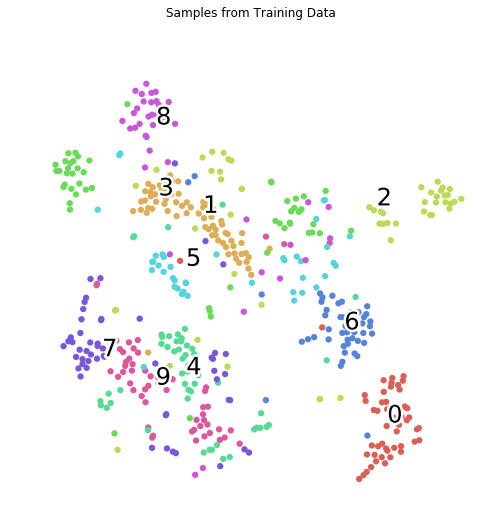

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

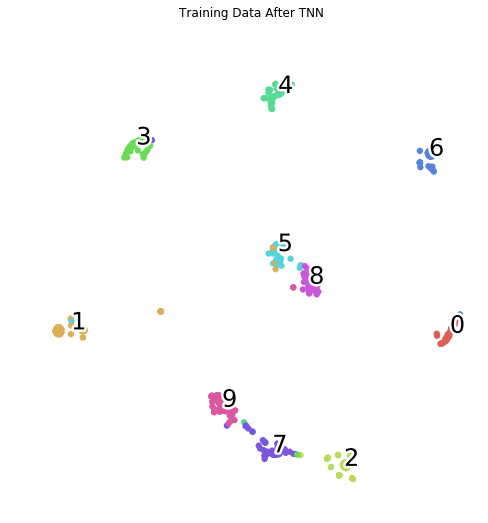

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-1.646187,4.600009,5.0
1,29.978218,-7.271741,0.0
2,1.266596,32.423031,4.0
3,-41.041939,-5.710828,1.0
4,-12.677921,-17.887129,9.0


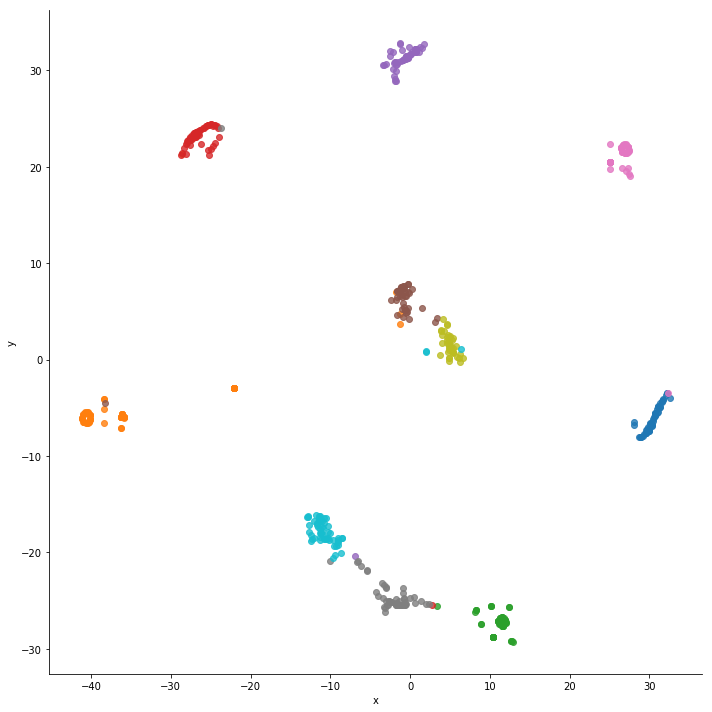

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

# Fastai

- How does the datablock API in fastai work?


- What is the use of Itembase and Imagelist classes?


- How to create custom classes?


- How to create custom dataset loader?

Don't worry if it becomes too much! We will discuss everything in context of Images below.

1. [ItemBase](https://github.com/fastai/fastai/blob/8f4a9e71554742ddcf57db5e9938c4bd6970d52f/fastai/core.py#L163) 

The journey starts with the base class called `ItemBase` class which determines the type of input and target seperately (it creates separate `ItemBase` classes for all inputs and targets). 

- Creating a custom subclass `ItemBase` class

Fastai provides 3 basic ItemBase classes : `Image`, `Text` and `TabularList`.  We can use one of these 3 classes as subclass to create custom `ItemBase` or  a custom `ItemBase` class.

Now why is there a need to create a custom `ItemBase` class or subclass? Consider our use case of siamese network where we need to input 3 or 2 images (depending on approach we take)  therefore we need to create custom `ItemBase` that takes in 3 or 2 images as input.

Steps :

- Create `ItemBase.data` is the data that is passed to PyTorch when we create DataLoader. This data will be passed to model
- Create `apply_tfms` to apply data augmentation to data. This will apply transformations when we call `get_transforms` using datablock API of fastai.


We will not be able to use this custom `ItemBase` unless we put it inside `ItemList`.

2. [ItemList](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L47)

This is the main class that allows you to group your inputs or your targets in the data block API. This class defines how we fetch (using `get` method), apply preprocesing(using `process` method), splitting(using `no_split`, `split_none`, `split_by_list`, `split_by_idxs`, `split_by_idx`, `split_by_folder`, `split_by_rand_pct`, `split_by_valid_func`, `split_by_files`, `split_by_fname_file` and `split_from_df`), labelling (using `_label_from_list`, `label_from_df`, `label_const`, `label_empty`, `label_from_func`, `label_from_folder` and `label_from_re`).

Steps:

- Define `_label_list` variable which contains type of label class. Fastai provide the label classes such as [CategoryList](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L359), [MultiCategoryList]() or [FloatList](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L422) depending on the type of the first item.
- Define `process` class which contains different [Preprocessor](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L38) which will be applied  to items at the end of the datablock API.  `processor` is applied to the ItemList after splitting and labelling.
- Define `_bunch` which contains name of classes and when we call .databunch(), the datablock API calls the `_bunch.create` method with `_bunch` as inputs.

3. [ItemLists](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L437)

A collection of ItemList (for inputs or targets) is together called ItemLists. This contains ItemList for each train, valid or test.

4. [LabelList](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L585)

`LabelList` takes a list of inputs and targets along with transforms. `LabelList` is subclass of PyTorch's class `Dataset`. It takes ItemList of inputs and ItemList of target. It takes inputs `ItemList` and labels `ItemList` as its properties `x` and `y`, sets property `item` to `None`, and uses `LabelList.transform` to apply a list of transforms `TfmList` to `x` and `y` if `tfm_y` is set `True`.

5. [LabelLists](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L510)

`LabelLists` is subclass of `ItemLists`. Labelists is a collection LabelList for each train, val or train. All the [preprocessing](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L486) happens during creation of LabelLists objects and transforms are applied after creating inputs and labels seperately to [either](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L489) if required.

An` ItemList` or its subclass object must do a split to turn itself into an `ItemLists` before doing labeling to become a` LabelLists` object.

6. [DataBunch]()

DataBunch is the final call in API. DataBunch object which consist of train DataLoader, val DataLoader and test DataLoader, created is used in Learner to train model.


---

Let's start with vision (Images)

Creating a databunch is our end goal in fastai. We will go through ways image dataset passes through different classes and subclasses.

Let's take a simple example :

<pre>
data = (ImageList.from_folder(path)           #Where to find the data? -> in path and its subfolders <br>
            .split_by_folder()                #How to split in train/valid? -> use the folders <br>
            .label_from_folder()              #How to label? -> depending on the folder of the filenames <br>
            .add_test_folder()                #Optionally add a test set (here default name is test) <br>
            .transform(tfms, size=64)         #Data augmentation? -> use tfms with a size of 64 <br>
            .databunch())                     #Finally? -> use the defaults for conversion to ImageDataBunch <br>
</pre>

ImageList class is subclass of ItemList. And as we saw above ItemList which itself is subclass of ItemBase is useful for allows to group inputs or targets. This class is created especially to deal with Images. Let's dissect [this class](https://github.com/fastai/fastai/blob/43001e17ba469308e9688dfe99a891018bcf7ad4/fastai/vision/data.py#L255) function by function.

`class ImageList(ItemList):` tell us that ImageList is derived from base class `ItemList`. <br> <br>
Next, `__init__` creates additional attributes like `convert_mode`, `after_open`, `c` and `sizes`.  ImageList being a custom ItemList class, when additional arguments are added to` __init__` call, it is necessary to pass these to [new](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L93) method in ItemList as this method is responsible for creating training and validation while splitting. To do that, we just add their names in the `copy_new` argument. <br> <br>
`open()` method  turn the `Path` object into an `Image` object by calling [open_image](https://github.com/fastai/fastai/blob/e6b56de53f80d2b2d39037c82d3a23ce72507cd7/old/fastai/dataset.py#L255) function. <br> <br>
`get` is most important method in ItemList. ImageList `get()` overwrites ItemList `get()` method where ImageList `get()` method tells how to get Images from filenames. That is the first line which calls ItemList get method which simply return whatever item is present at current index which is path object (filenames). The second line uses above open function and converts paths to images. The third line simply stores the sizes of input. <br> <br>
Now we come to `from_folder()` class method which is what is called in our datablock API. This method takes in input path, extensions which can be .jpg, .png, (Image extensions) etc and recurse=True which means it will recursively look for images as arguments and calls `from_folder()` [class method](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L113) of ItemList which in turn call `get_files()` [function](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L118).<br> <br>

Let's take a example and explain.<br>

To make it more solid, let's go through an example of Tiny MNIST. 

Download and get path <br>

```
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()
```

Now we call ItemList `from_folder()`, <br>

```
il_data_base = ItemList.from_folder(path=path_data, extensions=['.png'], include=['test'])
il_data_base
```

This will output ItemList object and [print](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L67) total number of items and 5 items.

```
ItemList (20 items)
/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png,/home/ubuntu/.fastai/data/mnist_tiny/test/5071.png,/home/ubuntu/.fastai/data/mnist_tiny/test/617.png,/home/ubuntu/.fastai/data/mnist_tiny/test/585.png,/home/ubuntu/.fastai/data/mnist_tiny/test/2032.png
Path: /home/ubuntu/.fastai/data/mnist_tiny
```

Now we call `get` [method](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L64) in ItemList and it return the item at 15th index.

```
il_data_base[15]

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test/6736.png')

```

We can get the same output by writing `il_data_base[15]` as `il_data_base.get([15])`.  Because the get method in ItemList returns the item at particular index. `self.items[i]`<br>

This was about `ItemList`. Now let's see what results do we obtain if we use `ImageList`.

```
il_data_image = ImageList.from_folder(path=path_data, extensions=['.png'], include=['test'])
il_data_image

ImageList (20 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_tiny

```

Calling from_folder class method from ImageList returns ImageList of 20 items and first 5 items (which in this case are not filenames but Image). How? It's because of get function of `ImageList` which calls `open()` function to convert filenames to Image. Hence, when we call 

```
il_data_image[15]

```
We get image as output.

---

Let's get back to ImageList class. There are various class method such as `from_df`, `from_csv`, etc which can also be called depending on dataset you have. The remaining methods are `show_xys` and `show_xyzs` which show input(xs) and target(ys) and input(xs), target(ys) and prediction(zs). <br><br>

Next, we have `split_by_folder()` which is [function](https://github.com/fastai/fastai/blob/cbc6d9b65bd122782a0084168022a526ef72b002/fastai/data_block.py#L198) in ItemList that splits the data depending on folder, where name of train dataset folder is `train` and validation dataset is `valid` which contains the image of each dataset.

Example: 

Download the Tiny MNIST dataset.

```
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()
```

This call as we seen above `from_folder` returns items as specified in `get` method.

```
il = ItemList.from_folder(path=path_data); il

ItemList (1439 items)
/home/ubuntu/.fastai/data/mnist_tiny/labels.csv,/home/ubuntu/.fastai/data/mnist_tiny/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/history.csv,/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv,/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png
Path: /home/ubuntu/.fastai/data/mnist_tiny
```

`split_by_folder` in ItemList splits the `il` ItemList into two smaller ItemList, one for train and another for valid.  Both `ImageList` are attached to a large `ItemLists` which is the final output of split_by_folder. The output is object of type `ItemLists` each containing two `ItemList` of Train and Valid.

```
sd = il.split_by_folder(train='train', valid='valid'); sd

ItemLists;

Train: ItemList (713 items)
/home/ubuntu/.fastai/data/mnist_tiny/train/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/train/3/9932.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/7189.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8498.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8888.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Valid: ItemList (699 items)
/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7692.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7484.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9157.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/8703.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9182.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Test: None
```
---

Now we understood how train and valid ImageList are created. There are various other splitting functions such as `split_by_func`, `split_from_df`, `split_by_rand_pct`,etc. Next is, how to label them. 

Labelling can be difficult as they are many different types of labels(like CategoryList, MultiCategoryList or FloatList). First the ItemList must find the type of label and this is done using `get_label_cls` [function](https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L257). This function returns `label_cls` or guess one from the first element of labels where `label_cls` can be one of the types of labels. If no `label_cls` argument is passed, the correct labeling type can usually be inferred based on the data (for classification or regression).

```
labels = ['7', '3']
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.CategoryList

labels = [7, 3]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.CategoryList

labels = [7.0, 3.0]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.FloatList

labels = [[7, 3],]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.MultiCategoryList

labels = [['7', '3'],]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.MultiCategoryList


```

Having inferred the type of label, we now call `label_from_folder()` to label `ItemLists` created above. Even when you just want a training set `ItemList`, you still need to do `split_none` to create an `ItemLists` and then do labeling with `label_from_folder`, to get `LabelLists`.


```
sd_train = ImageList.from_folder(path_data/'train').split_none()
ll_train = sd_train.label_from_folder(); ll_train

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Test: None

```
---

There are other labelling functions like `label_from_func`, `label_from_df`, `label_from_csv`, etc. Optionally, we can add test folder using `add_test_folder()` or `add_test()` methods.  After that comes the step of `preprocessing` which is not applied here. But it is invisible step that is it is not seen in the API but it is called depending on class of item from list of different `Preprocessor` class. There are different `Preprocessor` classes defined in fastai like `ObjectCategoryProcessor`, `SegmentationProcessor`,  `PointsProcessor`, etc. LabelLists calls `process` defined in `Preprocessor` class to complete the preprocessing. As, an example for text we can consider tokenization and then numericalization as preprocessing step done once. Also, filling missing values in Tabular data. <br><br>


But we have called `transform()` which applies transformations to the data on fly. Now the important difference betweene preprocessing and transformation is that preprocessing is applied once and transformation is applied on the fly to the data while training. The transformations are applied to `x`s of training and validation datasets.<br>

There are various [data augmentation and transformation techniques](https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py) for Image such  as flip, add_padding, rotation, lightining, etc. which can be used as regularization to create a robust model.

---

The last step is creating DataBunch which is called using `databunch()` in the API. `DataBunch.create()` is invoked and [it](https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L543) includes many arguments like bs(batch size), num_workers, etc.

Important point to note is the class called to create `DataBunch` is set in `_bunch` variable which can be seen on [first line](https://github.com/fastai/fastai/blob/43001e17ba469308e9688dfe99a891018bcf7ad4/fastai/vision/data.py#L257) of `class ImageList` which is set to `ImageDataBunch`.  `ImageDataBunch` is subclass of `DataBunch` created for convinence of handling Images same like how `ImageList` is created from `ItemList` to handle vision applications. `ImageDataBunch` contains `normalize` function which is called to normalize the whole dataset for given mean and std.

And thus the goal of creating databunch is reached.

---

### Recap

That was a lot to take in!

Let's see if we can summarize it in few lines.

- First we called `from_folder` from ImageList class which takes `path` as argument to return Images as `ItemList` output.<br>

- Secondly, we sepcify how we want to split our Image dataset into train and valid. This convets `ItemList` into `ItemLists`. We saw if we only want training set without valid, we still need to specify `split_none()` so as to convert `ItemList` into `ItemLists` of train and valid.<br>

- Rraining, validation even testing ItemList get to call `label_from_folder`, and then turns the `ItemLists` into a `LabelLists` and then calls `LabelLists.process` to perform preprocessing.

- We can additionally add `transform` functions and `test` set if we want.

- The final step is calling `databunch` which creates the dataloader of train and test which will be used to do a forward pass and backward pass by passing the dataloader to `Learner` class which defines a model architectures and trains the model.



In [0]:
!pip install pyfunctional

In [0]:
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from fastai import *
from fastai.vision import *
from fastai.vision import learner
from fastai.callbacks import *
import pandas as pd
from functional import seq
%matplotlib inline

In [0]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/models'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
tfms = get_transforms(do_flip=False)
bs = 64

#### Convert images and targets to dataframe

In [0]:
ll = ImageList.from_folder(path).split_by_folder(train='training', valid='testing').label_from_folder().train
ll.to_csv('/content/train.csv')

In [0]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,x,y
0,training/8/30322.png,8
1,training/8/7825.png,8
2,training/8/32181.png,8
3,training/8/16579.png,8
4,training/8/5435.png,8


In [0]:
print (df_train['y'].value_counts())

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: y, dtype: int64


## Method - 1 (Triplet Loss)

In [0]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1 = df_train.copy()
df1['target'] = 1
df2 = df_train.copy()
df2['target'] = 0
df1 = df1.append(df2)
df1.head()

,x,y,target
0,training/8/30322.png,8,1
1,training/8/7825.png,8,1
2,training/8/32181.png,8,1
3,training/8/16579.png,8,1
4,training/8/5435.png,8,1


In [0]:
df1.shape

(120000, 3)

In [0]:
mean, std = torch.tensor(mnist_stats)

# The primary difference from the tutorial is with how normalization is being done here
class SiameseImagePair(ItemBase):
    def __init__(self, img1, img2, img3): ## These should of Image type
        self.img1, self.img2, self.img3 = img1, img2, img3
        self.obj, self.data = (img1, img2, img3), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None], (img3.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.img3 = self.img3.apply_tfms(tfms, *args, **kwargs)
        
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None], (self.img3.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape, self.img3.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data, 2)*std[...,None,None])


In [0]:
class SiameseImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object

        #print (self.inner_df)
        imgs = self.inner_df.x.values
        classes = self.inner_df.y.values
        wcls = classes[i]
        simgs = imgs[classes == wcls]
        dimgs = imgs[classes != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0]][0]
                    fn3 = [dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
            fn3 = self.items[np.where(imgs==fn3)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        img3 = super().open(fn3) # Returns Image class object
        
        return SiameseImagePair(img1, img2, img3)

    def reconstruct(self, t): return SiameseImagePair(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None], mean[...,None,None]+t[2]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [0]:
data = (SiameseImageList.from_df(df1, path, cols=0, convert_mode='L')
        .split_by_rand_pct(0.2, seed=34)
        .label_empty()
        .transform(tfms, size=28)
        .databunch(bs=bs))

In [0]:
data

ImageDataBunch;

Train: LabelList (96000 items)
x: SiameseImageList
SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))
y: EmptyLabelList
,,,,
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (24000 items)
x: SiameseImageList
SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Siz

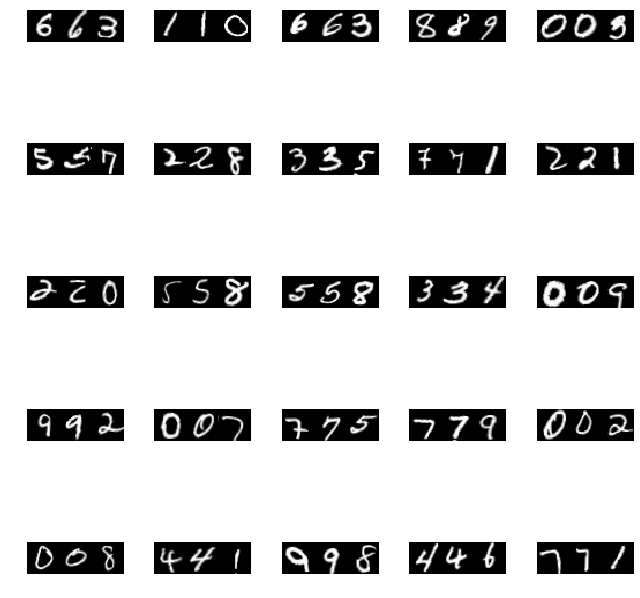

In [0]:
data.show_batch(rows=5)

In [0]:
class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet18, lin_ftrs=[256, 128], emb_sz=128, ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body)*2, self.emb_sz, self.lin_ftrs, self.ps, True, self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

    def forward(self, x1, x2, x3):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        output3 = self.cnn(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.cnn(x)

In [0]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, ops, target, size_average=True):
        anchor, positive, negative = ops[0], ops[1], ops[2]
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [0]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func = TripletLoss().cuda()

In [0]:
siamese_learner = Learner(data, model, loss_func=loss_func)

In [0]:
siamese_learner.model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


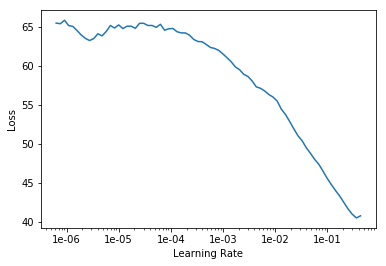

In [0]:
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [0]:
lr = 1e-2
siamese_learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.193565,0.140230,15:01
1,0.133426,0.103191,15:05
2,0.074834,0.022716,15:06
3,0.029088,0.008835,14:58
4,0.013166,0.005491,15:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


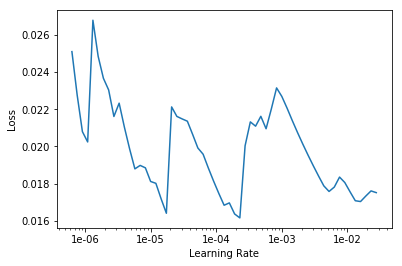

In [0]:
siamese_learner.unfreeze()
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [0]:
lr = 1e-5
siamese_learner.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,time
0,0.014316,0.005476,15:09
1,0.010526,0.005735,15:10


In [0]:
siamese_learner.save('mnist.pth')

#### t-SNE visualization

In [0]:
db = ImageList.from_folder(path).split_by_folder(train='training', valid='testing').label_from_folder().transform(tfms, size=28).databunch()
db

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for x, y in dl:
            size = x.shape[0]
            preds[start:start+size,:] = model.get_embedding(x)
            start+= size
        return preds

In [0]:
dl = db.valid_dl
ds = db.valid_ds

In [0]:
from tqdm import tqdm
val_arr = []
labels = []
for i in tqdm(range(len(ds))):
    val_arr.append(ds.x[i].data.numpy())
    labels.append(int(ds.y[i]))

val_arr = np.array(val_arr)
labels = np.array(labels)

val_arr.shape, labels.shape

100%|██████████| 10000/10000 [00:03<00:00, 2628.17it/s]


((10000, 3, 28, 28), (10000,))

In [0]:
res = extract_embedding(dl, ds, model)
res.shape

torch.Size([10000, 128])

In [0]:
#convert into tensor
tensor_x = res
tensor_y = torch.from_numpy(labels)

In [0]:
import torch.utils.data as utils

my_dataset = utils.TensorDataset(tensor_x, tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset, shuffle=True) # create your dataloader

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

net = nn.Sequential(nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 10))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net = net.cuda()

In [0]:
for epoch in range(10):  # loop over the dataset multiple times
    
    correct = 0.0
    running_loss = 0.0
    total = 0.0
    for i, my_data in enumerate(my_dataloader, 0):
        # get the inputs
        inp, lbl = my_data
        inp = inp.cuda()
        lbl = lbl.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inp)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == lbl).sum().item()
        total += lbl.size(0)
        
        # print statistics
        running_loss += loss.item()
        if i % 10000 == 9999:    # print every 2000 mini-batches
            print('Epoch: %d, loss: %.3f Acc: %.2f' %
                  (epoch + 1, running_loss / 10000, correct/total))
            running_loss = 0.0

print('Finished Training')

Epoch: 1, loss: 0.672 Acc: 0.80
Epoch: 2, loss: 0.318 Acc: 0.90
Epoch: 3, loss: 0.296 Acc: 0.90
Epoch: 4, loss: 0.288 Acc: 0.90
Epoch: 5, loss: 0.278 Acc: 0.91
Epoch: 6, loss: 0.276 Acc: 0.91
Epoch: 7, loss: 0.272 Acc: 0.91
Epoch: 8, loss: 0.268 Acc: 0.91
Epoch: 9, loss: 0.265 Acc: 0.91
Epoch: 10, loss: 0.265 Acc: 0.91
Finished Training


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
val_arr_new = val_arr.reshape(val_arr.shape[0], -1)
val_arr_new.shape

(10000, 2352)

In [0]:
import random
rnd_index = random.sample(range(0, 10000), 500)

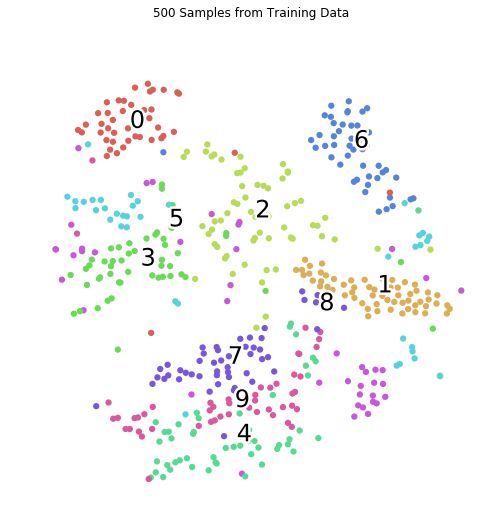

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(val_arr_new[rnd_index])
scatter(train_tsne_embeds, np.array(labels)[rnd_index], "500 Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(labels[rnd_index])
l[:5]

array([9, 0, 7, 2, 2])

In [0]:
preds = res[rnd_index].numpy()
preds_trans = TSNE().fit_transform(preds)

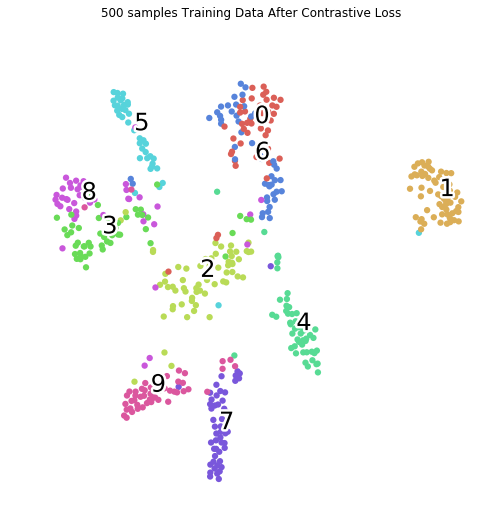

In [0]:
scatter(preds_trans, l, "500 samples Training Data After Contrastive Loss")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-5.835670,-13.450363,9.0
1,-0.764932,1.078476,0.0
2,-0.051756,-16.334019,7.0
3,-2.442553,-3.660281,2.0
4,-10.724786,-0.516755,2.0


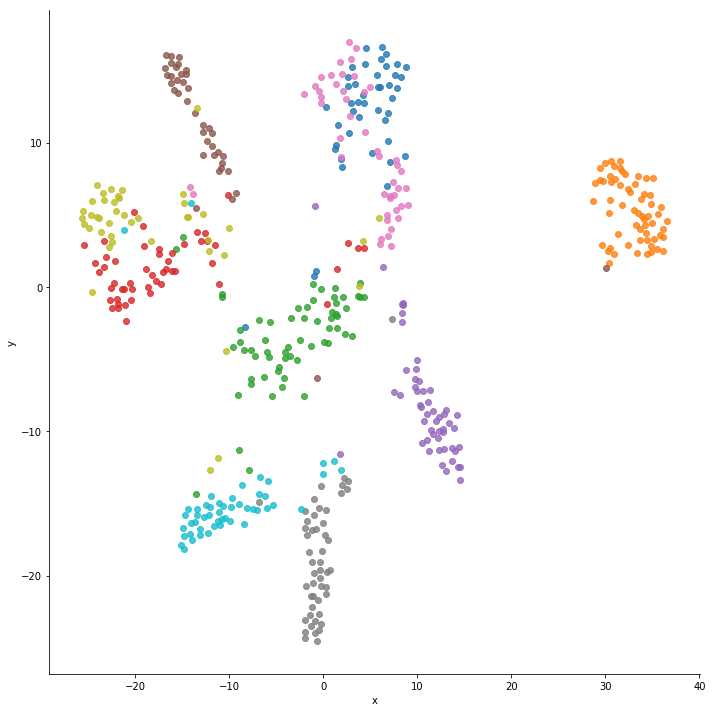

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

## Method - 2 (Contrastive Loss)


### Approach - 1 (Using Custom ItemBase and Custom ItemList)

Code Credits: [Alex Fitts](http://afitts.github.io/2018/12/03/humpback-siamese/)

####  Create a custom ItemBase class to read two images

In [0]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1 = df_train.copy()
df1['target'] = 1
df2 = df_train.copy()
df2['target'] = 0
df1 = df1.append(df2)
df1.head()

,x,y,target
0,training/2/35250.png,2,1
1,training/2/35872.png,2,1
2,training/2/27781.png,2,1
3,training/2/2700.png,2,1
4,training/2/21254.png,2,1


In [0]:
df1.shape

(120000, 3)

In [0]:
mean, std = torch.tensor(mnist_stats)

# The primary difference from the tutorial is with how normalization is being done here
class SiameseImagePair(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])


In [0]:
class SiameseImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object

        #print (self.inner_df)
        imgs = self.inner_df.x.values
        classes = self.inner_df.y.values
        wcls = classes[i]
        simgs = imgs[classes == wcls]
        dimgs = imgs[classes != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        return SiameseImagePair(img1, img2)

    def reconstruct(self, t): return SiameseImagePair(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [0]:
data = (SiameseImageList.from_df(df1, path, cols=0, convert_mode='L')
        .split_by_rand_pct(0.2, seed=34)
        .label_from_df(cols='target')
        .transform(tfms, size=28)
        .databunch(bs=bs))

In [0]:
data

ImageDataBunch;

Train: LabelList (96000 items)
x: SiameseImageList
SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))
y: CategoryList
1,1,1,1,1
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (24000 items)
x: SiameseImageList
SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28])),SiameseImagePair (torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))
y: CategoryList
1,0,1,0,1
Path: /root/.fastai/data/mnist_png;

Test: None

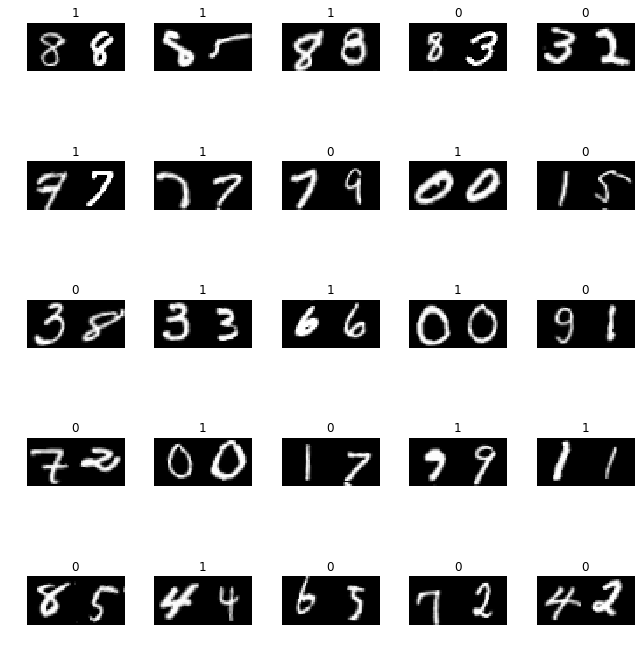

In [0]:
data.show_batch(rows=5)

In [0]:
data.classes, len(data.classes)

([0, 1], 2)

In [0]:
class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet18, lin_ftrs=[256, 128], emb_sz=128, ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body), self.emb_sz, self.lin_ftrs, self.ps, self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [0]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist.float()*target.float()
        ndist = dist.float()*(1-target.float())
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

In [0]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func = ContrastiveLoss().cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 70996250.25it/s]


In [0]:
# model.summary()

In [0]:
siamese_learner = Learner(data, model, loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


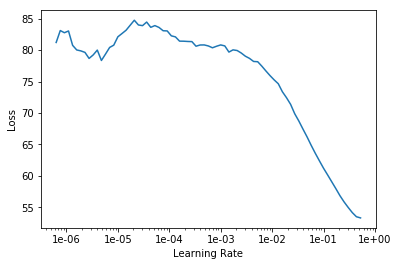

In [0]:
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [0]:
lr = 1e-1
siamese_learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,8.966630,11.344313,10:12
1,9.088272,11.493024,10:04
2,8.351510,12.722130,09:58
3,7.598961,12.626108,10:02
4,7.006391,13.433698,09:53


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


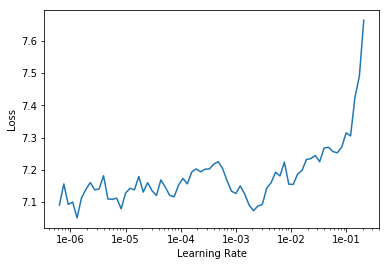

In [0]:
siamese_learner.unfreeze()
siamese_learner.lr_find()
siamese_learner.recorder.plot()

In [0]:
lr = 5e-4
siamese_learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,7.113893,13.318987,10:11
1,7.217685,13.327180,10:02
2,7.359030,13.419391,10:26
3,7.028635,13.536593,10:34
4,6.989374,13.572573,10:30


##### t-SNE visualization

In [0]:
siamese_learner.model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [0]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        arrs = np.zeros((len(ds), 3, 28, 28))
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            arrs[start:start+size,:] = x[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds, arrs

In [0]:
dl = data.valid_dl
ds = data.valid_ds

In [0]:
res, val_arr = extract_embedding(dl, ds, model)
res.shape, val_arr.shape

(torch.Size([24000, 128]), (24000, 3, 28, 28))

In [0]:
labels = list(map(lambda x:int(x.split('/')[-2]), data.valid_ds.items))
print (len(labels), labels[:5])

24000 [1, 0, 0, 5, 3]


In [0]:
#convert into tensor
tensor_x = res
tensor_y = torch.from_numpy(np.array(labels))

In [0]:
import torch.utils.data as utils

my_dataset = utils.TensorDataset(tensor_x, tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset) # create your dataloader

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


net = nn.Sequential(nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 10))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net = net.cuda()

In [0]:
for epoch in range(10):  # loop over the dataset multiple times
    
    correct = 0.0
    running_loss = 0.0
    total = 0.0
    for i, my_data in enumerate(my_dataloader, 0):
        # get the inputs
        inp, lbl = my_data
        inp = inputs.cuda()
        lbl = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inp)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == lbl).sum().item()
        total += lbl.size(0)
        
        # print statistics
        running_loss += loss.item()
        if i % 24000 == 23999:    # print every 2000 mini-batches
            print('Epoch :%d, loss: %.3f Acc: %.2f' %
                  (epoch + 1, running_loss / 2000, correct/total))
            running_loss = 0.0

print('Finished Training')

Epoch :1, loss: 2.937 Acc: 0.93
Epoch :2, loss: 2.180 Acc: 0.95
Epoch :3, loss: 2.087 Acc: 0.95
Epoch :4, loss: 2.043 Acc: 0.95
Epoch :5, loss: 1.998 Acc: 0.95
Epoch :6, loss: 1.965 Acc: 0.96
Epoch :7, loss: 1.953 Acc: 0.96
Epoch :8, loss: 1.943 Acc: 0.96
Epoch :9, loss: 1.932 Acc: 0.96
Epoch :10, loss: 1.921 Acc: 0.96
Finished Training


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
val_arr_new = val_arr.reshape(val_arr.shape[0], -1)
val_arr_new.shape

(24000, 2352)

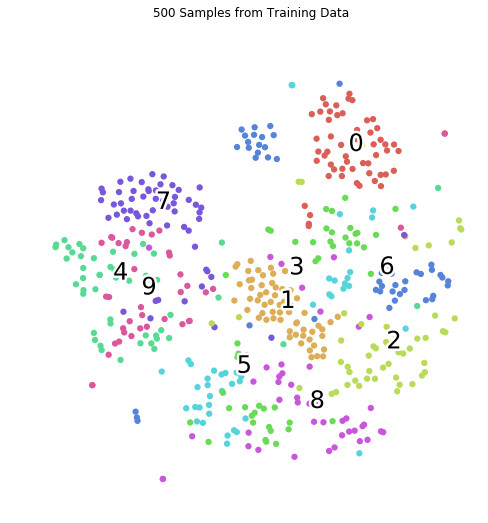

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(val_arr_new[:500])
scatter(train_tsne_embeds, np.array(labels)[:500], "500 Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(labels[:500])
l[:5]

array([1, 0, 0, 5, 3])

In [0]:
preds = res[:500].numpy()
preds_trans = TSNE().fit_transform(preds)

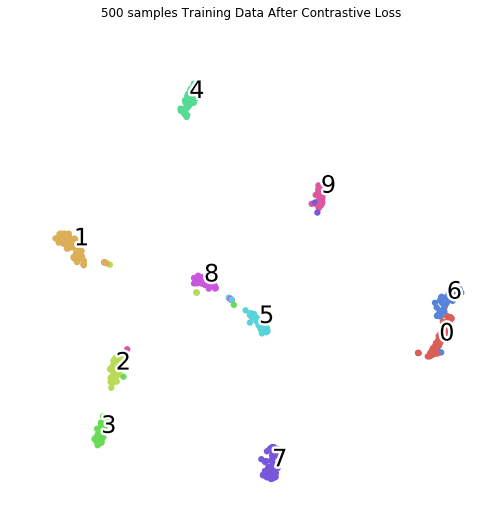

In [0]:
scatter(preds_trans, l, "500 samples Training Data After Contrastive Loss")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-26.003435,13.621143,1.0
1,34.876019,-6.976045,0.0
2,34.935696,-6.623022,0.0
3,3.282708,0.642563,5.0
4,-20.537497,-25.558765,3.0


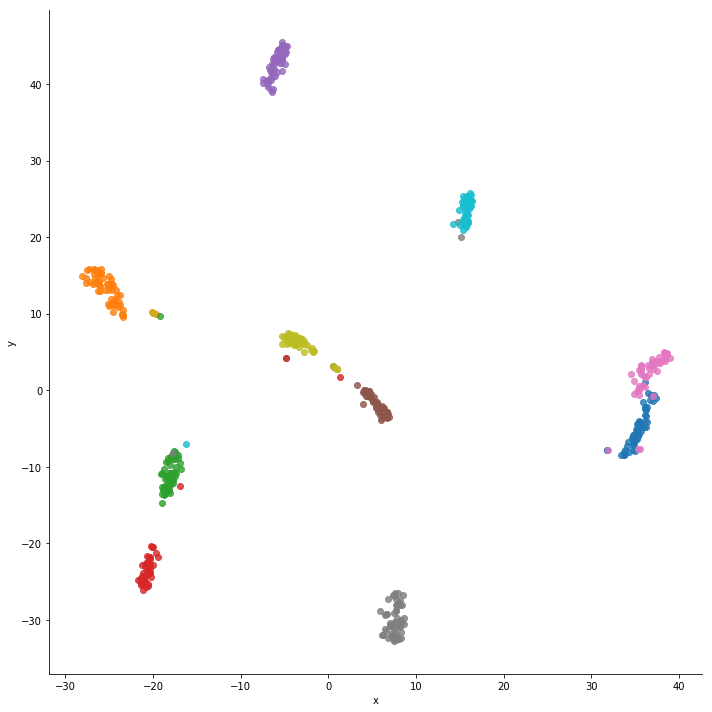

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

### Approach - 2 (Using Custom DataBunch)

Code Credits: [Radek](https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb)

In [0]:
data = (ImageList.from_folder(path)
        .split_by_folder(train='training', valid='testing')
        .label_from_folder())

In [0]:
data

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
df = pd.read_csv('/content/train.csv')
df.head()

,x,y
0,training/6/51370.png,6
1,training/6/59673.png,6
2,training/6/36175.png,6
3,training/6/57143.png,6
4,training/6/2930.png,6


In [0]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.class_ids = ds.y.items
        
    def __len__(self):
        return 2 * len(self.ds)
    
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_same(idx // 2)
        else: 
            return self.sample_different((idx-1) // 2)
        
    def sample_same(self, idx):
        class_id = self.class_ids[idx]        
        candidates = list(np.where(self.class_ids == class_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    
    def sample_different(self, idx):
        class_id = self.class_ids[idx]
        candidates = list(np.where(self.class_ids != class_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [0]:
train_dl = DataLoader(
    TwoImDataset(data.train),
    batch_size=bs,
    shuffle=True
)
valid_dl = DataLoader(
    TwoImDataset(data.valid),
    batch_size=bs,
    shuffle=False
)

data = ImageDataBunch(train_dl, valid_dl)

In [0]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in mnist_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [0]:
data.add_tfm(normalize_batch)

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)
        
    def forward(self, im_A, im_B):
        # dl - distance layer
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        dl = self.calculate_distance(x1, x2)
        out = self.head(dl)
        return out
    
    def process_features(self, x): return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [0]:
learn = Learner(data, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 20454218.82it/s]


In [0]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

Learner(data=ImageDataBunch;

Train: <__main__.TwoImDataset object at 0x7fab2f514a20>;

Valid: <__main__.TwoImDataset object at 0x7fab2f5149e8>;

Test: None, model=SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, 

In [0]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


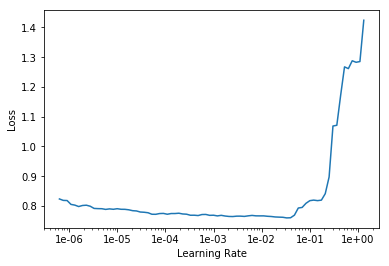

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,,time
0,0.131680,0.100162,0.963450,12:34
1,0.078730,0.043282,0.984900,12:47
2,0.040047,0.027837,0.990100,12:40
3,0.028438,0.022997,0.991600,12:43


In [0]:
learn.unfreeze()

In [0]:
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [0]:
learn.fit_one_cycle(2, lrs)

epoch,train_loss,valid_loss,,time
0,0.029067,0.024276,0.991950,12:54
1,0.016099,0.016919,0.994050,13:05


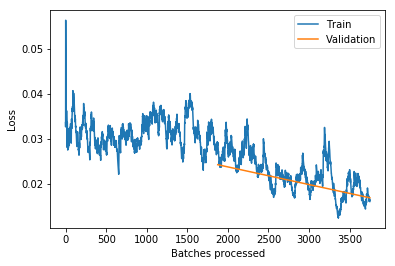

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('mnist_model')

#### t-SNE visualization

In [0]:
learn.model

SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [0]:
targs = []
feats = []
learn.model.eval()
for (x, y), ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(x)).detach().cpu())
    targs.append(ts)

In [0]:
val_arr = [x.numpy() for t in feats for x in t]
val_arr = np.array(val_arr)
res = list(val_arr)[::2] #extract only odd or even index as there is repetition
res = np.array(res)
val_targs = [x for t in targs for x in t]
val_targs = np.array(val_targs)

print (res.shape, val_arr.shape, val_targs.shape)

(10000, 512) (20000, 512) (20000,)


In [0]:
ll = ImageList.from_folder(path).split_by_folder(train='training', valid='testing').label_from_folder().valid
ll.to_csv('/content/test.csv')

In [0]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,x,y
0,testing/6/7925.png,6
1,testing/6/8083.png,6
2,testing/6/559.png,6
3,testing/6/5481.png,6
4,testing/6/7409.png,6


In [0]:
labels = np.array(df_test['y'].values.tolist())

In [0]:
res.shape, labels.shape

((10000, 512), (10000,))

In [0]:
#convert into tensor
tensor_x = torch.from_numpy(res)
tensor_y = torch.from_numpy(np.array(labels))

In [0]:
import torch.utils.data as utils

my_dataset = utils.TensorDataset(tensor_x, tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset) # create your dataloader

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


net = nn.Sequential(nn.Linear(512, 64),
                    nn.ReLU(),
                    nn.Linear(64, 10))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net = net.cuda()

In [0]:
for epoch in range(10):  # loop over the dataset multiple times
    
    correct = 0.0
    running_loss = 0.0
    total = 0.0
    for i, my_data in enumerate(my_dataloader, 0):
        # get the inputs
        inp, lbl = my_data
        inp = inp.cuda()
        lbl = lbl.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inp)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == lbl).sum().item()
        total += lbl.size(0)
        
        # print statistics
        running_loss += loss.item()
        if i % 10000 == 9999:    # print every 2000 mini-batches
            print('Epoch :%d, loss: %.3f Acc: %.2f' %
                  (epoch + 1, running_loss / 10000, correct/total))
            running_loss = 0.0

print('Finished Training')

Epoch :1, loss: 0.205 Acc: 0.96
Epoch :2, loss: 0.020 Acc: 0.99
Epoch :3, loss: 0.006 Acc: 1.00
Epoch :4, loss: 0.006 Acc: 1.00
Epoch :5, loss: 0.007 Acc: 1.00
Epoch :6, loss: 0.006 Acc: 1.00
Epoch :7, loss: 0.007 Acc: 1.00
Epoch :8, loss: 0.006 Acc: 1.00
Epoch :9, loss: 0.008 Acc: 1.00
Epoch :10, loss: 0.008 Acc: 1.00
Finished Training


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
rnd_index = random.sample(range(0, 10000), 1000)

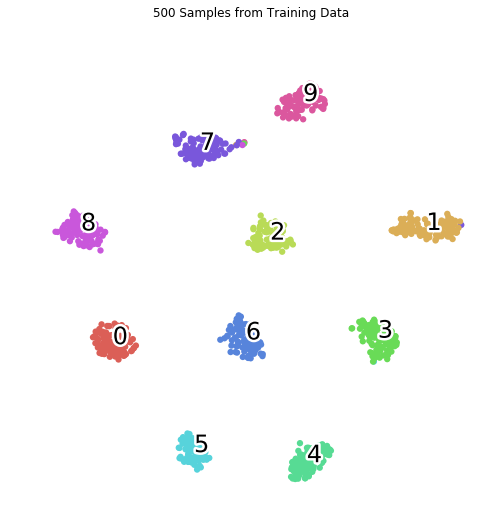

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(res[rnd_index])
scatter(train_tsne_embeds, np.array(labels)[rnd_index], "500 Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(labels[rnd_index])
l[:5]

array([0, 2, 0, 7, 7])

In [0]:
preds = res[rnd_index]
preds_trans = TSNE().fit_transform(preds)

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-5.754615,-9.986732,0.0
1,-23.744156,-23.395639,2.0
2,-5.264265,-10.759423,0.0
3,6.177976,6.828172,7.0
4,5.337191,3.906974,7.0


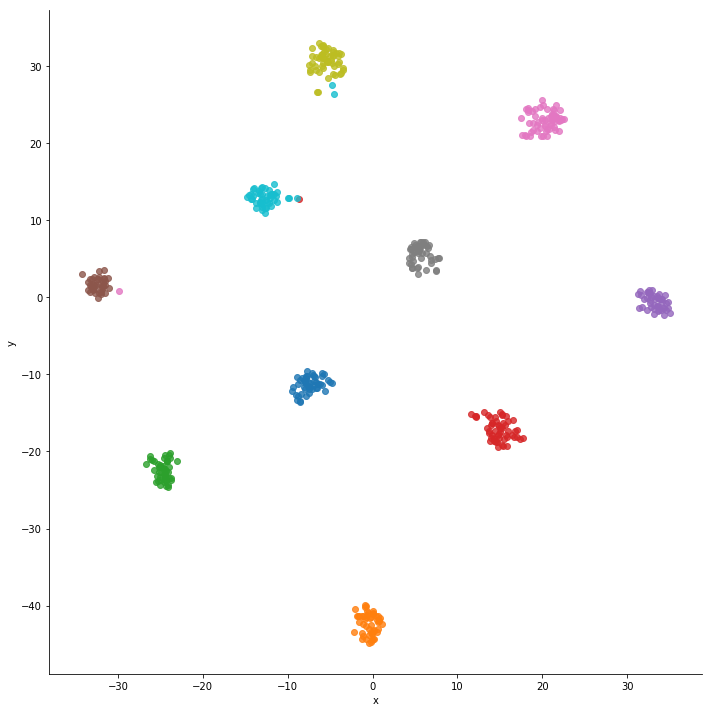

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)